In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import datetime

In [2]:

dataset = keras.utils.image_dataset_from_directory(
    "Dataset",
    label_mode=None,
    image_size=(128,128),
    batch_size=128,
    smart_resize=True,
    shuffle = True
)

Found 4319 files belonging to 1 classes.


In [4]:
dataset = dataset.map(lambda x: (x-127.5)/127.5)


In [6]:

discriminator = keras.Sequential(
[
keras.Input(shape=(128, 128, 3)),
layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
layers.BatchNormalization(),
layers.LeakyReLU(alpha=0.2),
layers.Dropout(0.3),
layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
layers.BatchNormalization(),
layers.LeakyReLU(alpha=0.2),
layers.Dropout(0.3),
layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
layers.BatchNormalization(),
layers.LeakyReLU(alpha=0.2),
layers.Dropout(0.3),
layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
layers.BatchNormalization(),
layers.LeakyReLU(alpha=0.2),
layers.Dropout(0.3),
layers.Flatten(),
layers.Dense(1, activation="sigmoid"),
],
name="discriminator",
)

In [7]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                     

In [8]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 1024),
        layers.Reshape((8, 8, 1024)),

        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"),
        

    ],
    name="generator",
)

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 65536)             6619136   
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      8389120   
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 512)      2048      
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      20

In [10]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.2 * tf.random.normal(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=9, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        #fig = plt.figure(figsize=(3,3))
        for i in range(self.num_img):
            plt.subplot(3, 3, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.axis("off")
            plt.imshow(img);
        plt.suptitle(epoch)
        plt.savefig(f"Generated Images\large\generated_img_{epoch:03d}_{i}.png")

Epoch 1/2000
34/34 [==============================] - 14s 259ms/step - d_loss: 0.4921 - g_loss: 0.6907
Epoch 2/2000
34/34 [==============================] - 8s 216ms/step - d_loss: 0.3429 - g_loss: 0.8105
Epoch 3/2000
34/34 [==============================] - 8s 213ms/step - d_loss: 0.2434 - g_loss: 1.0725
Epoch 4/2000
34/34 [==============================] - 8s 212ms/step - d_loss: 0.1066 - g_loss: 2.0807
Epoch 5/2000
34/34 [==============================] - 8s 210ms/step - d_loss: 0.0213 - g_loss: 3.7265
Epoch 6/2000
34/34 [==============================] - 8s 212ms/step - d_loss: 0.0517 - g_loss: 4.8829
Epoch 7/2000
34/34 [==============================] - 8s 214ms/step - d_loss: 0.0677 - g_loss: 4.3622
Epoch 8/2000
34/34 [==============================] - 9s 227ms/step - d_loss: 0.0603 - g_loss: 4.3535
Epoch 9/2000
34/34 [==============================] - 9s 224ms/step - d_loss: 0.0533 - g_loss: 5.9465
Epoch 10/2000
32/34 [===========================>..] - ETA: 0s - d_loss: 0.0477 -

KeyboardInterrupt: 

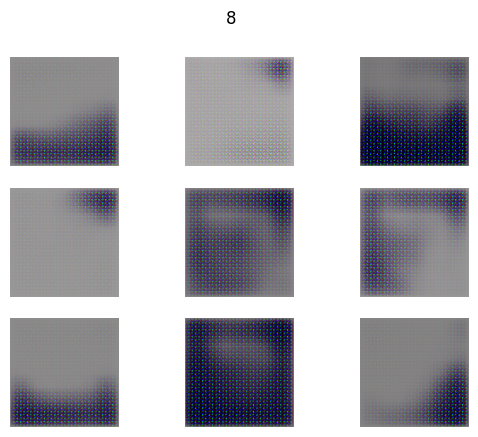

In [12]:
epochs = 2000
gan = GAN(discriminator=discriminator, generator=generator,
latent_dim=latent_dim)
gan.compile(
d_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
g_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
loss_fn=keras.losses.BinaryCrossentropy(),
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gan.fit(
dataset, epochs=epochs,
callbacks=[GANMonitor(num_img=9, latent_dim=latent_dim), tensorboard_callback]
)

In [60]:
generator.save(r'savedmodels\DCGAN128x128_1203-401Epochs.h5')

In [61]:
discriminator.save(r'savedmodels\DCGAN128x128_1203-401EpochsDis.h5')

In [228]:
num = 1
random_vector = tf.random.normal(shape=(num, 100))
images = generator(random_vector)
images *= 127.5
images += 127.5
print(tf.shape(images[0]))

for x in range(num):
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img)

NameError: name 'generator' is not defined

In [4]:
import tensorflow as tf
new_model = tf.keras.models.load_model('savedmodels\DCGAN128x128_1203Epochs.h5')


1/1 [==============================] - 0s 254ms/step
tf.Tensor([128 128   3], shape=(3,), dtype=int32)


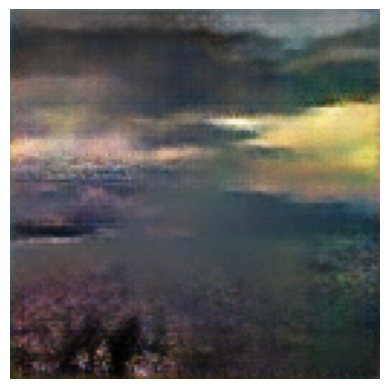

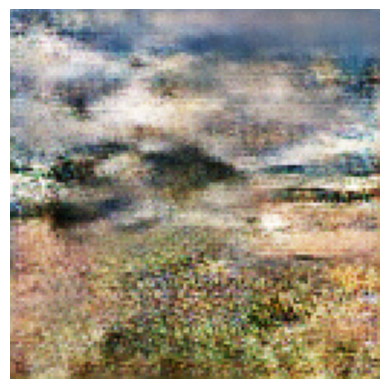

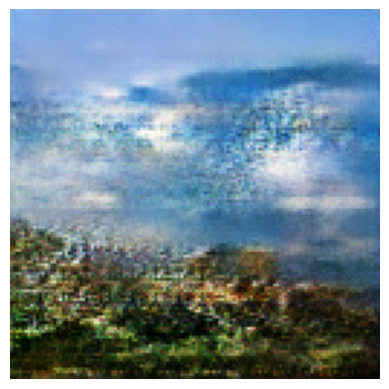

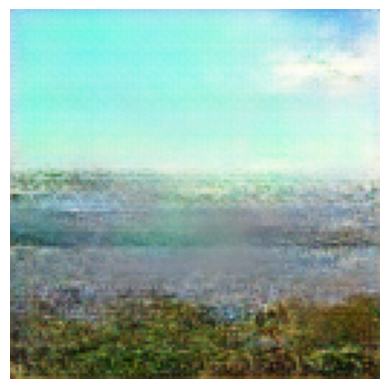

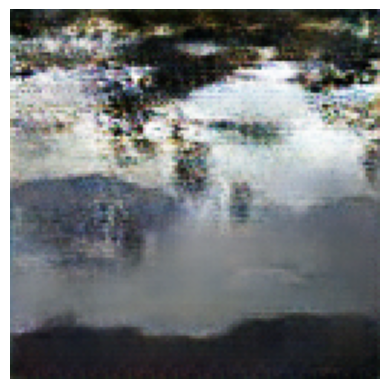

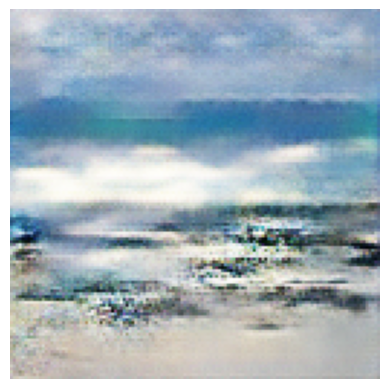

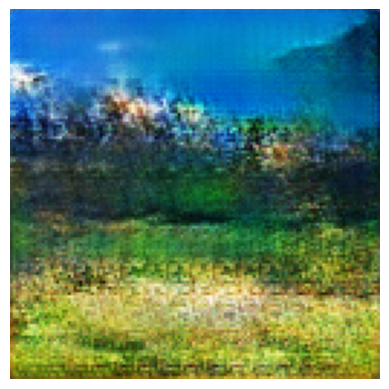

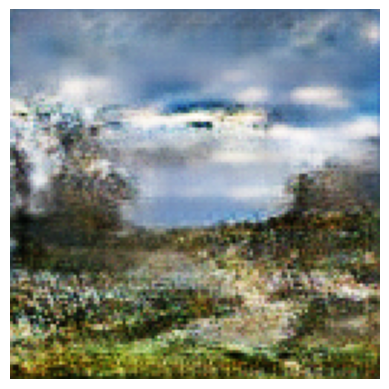

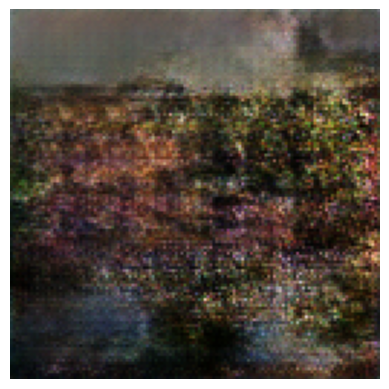

<Figure size 640x480 with 0 Axes>

In [15]:
num = 9
random_vector = tf.random.normal(shape=(num, 100))
images = new_model.predict(random_vector)
images *= 127.5
images += 127.5
print(tf.shape(images[0]))

for x in range(num):
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    
    plt.imshow(img)
    plt.figure()

In [3]:
new_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 65536)             6619136   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 16, 16, 512)      8389120   
 ranspose)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 16, 16, 512)      2048      
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 256)      20

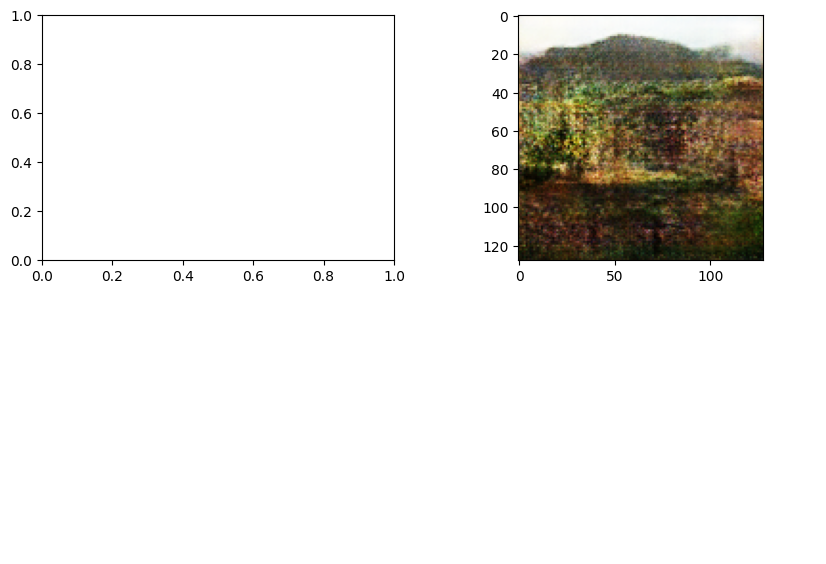

In [17]:
num = 1
random_vector = tf.random.normal(shape=(num, 100))
# images = generator(random_vector)
# images *= 127.5
# images += 127.5
images2 = new_model(random_vector)
images2 *= 127.5
images2 += 127.5
fig = plt.figure(figsize=(10, 7))
for x in range(num):
    # img = keras.utils.array_to_img(images[x])
    img2 = keras.utils.array_to_img(images2[x])
    plt.axis("off")
    fig.add_subplot(2, 2, 1)
    # plt.imshow(img)
    fig.add_subplot(2, 2, 2)
    plt.imshow(img2)







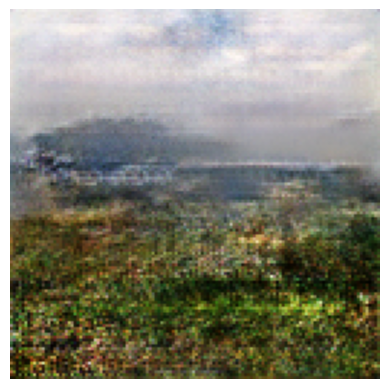

In [183]:
for x in range(num):
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img)
    

In [ ]:
new_model.summary()

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)
mixed_precision.set_global_policy('float32')

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


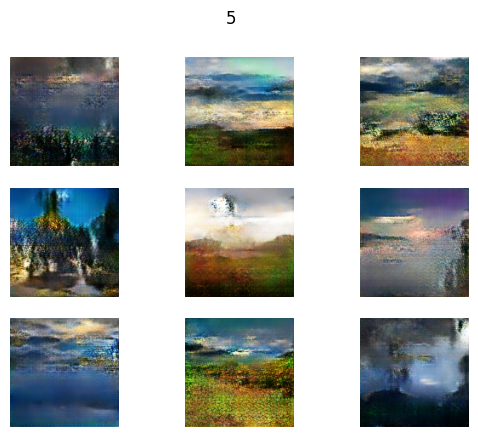

In [206]:
num = 9
random_vector = tf.random.normal(shape=(num, 100))
images = new_model(random_vector)
images *= 127.5 
images += 127.5
# print(images)
# print(tf.shape(images[0]))

for x in range(num):
    plt.subplot(3, 3, x+1)
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img);
plt.suptitle(5)
plt.savefig('test.png')

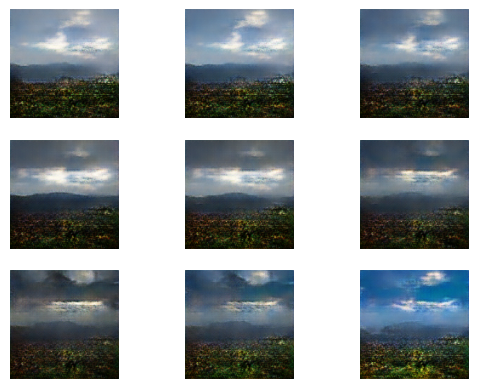

In [308]:
num = 9
random_vector = tf.random.normal(shape=(num, 100))

# print(images)
# print(tf.shape(images[0]))

for x in range(num):
    images = new_model(random_vector)
    images *= 127.5 
    images += 127.5
    plt.subplot(3, 3, x+1)
    img = keras.utils.array_to_img(images[1])
    plt.axis("off")
    plt.imshow(img);
    random_vector -= 0.2*tf.random.normal(shape=(1,100))

    

In [43]:
print(tf.random.uniform([1]))

tf.Tensor([0.53046584], shape=(1,), dtype=float32)
